# Example that use the code implemented for FUCONE

In [1]:
import os.path as osp
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import gzip
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import hashlib

from mne import get_config, set_config, set_log_level, EpochsArray
from mne.connectivity import spectral_connectivity
from mne.connectivity import envelope_correlation
from mne.viz import plot_connectivity_circle
from moabb.evaluations.base import BaseEvaluation
from mne.epochs import BaseEpochs

from scipy import stats as spstats

from sklearn.base import clone
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import StackingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import (
    LogisticRegression,
)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.covariance import ledoit_wolf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import get_scorer, balanced_accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier


from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import FgMDM
from pyriemann.estimation import Coherences

from moabb.datasets import (
    Schirrmeister2017,  
    Cho2017
)
from moabb.paradigms import LeftRightImagery, MotorImagery


#from fc_pipeline import (
#    FunctionalTransformer,
#    EnsureSPD,
#    FC_DimRed,
#    GetDataMemory,
#    GetData,
#    WithinSessionEvaluationFCDR
#)

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


In [2]:
def _compute_fc_subtrial(epoch, delta=1, ratio=0.5, method="coh", fmin=8, fmax=35):
    """Compute single trial functional connectivity (FC)

    Most of the FC estimators are already implemented in mne-python (and used here from
    mne.connectivity.spectral_connectivity and mne.connectivity.envelope_correlation).
    The epoch is split into subtrials.

    Parameters
    ----------
    epoch: MNE epoch
        Epoch to process
    delta: float
        length of the subtrial in seconds
    ratio: float, in [0, 1]
        ratio overlap of the sliding windows
    method: string
        FC method to be applied, currently implemented methods are: "coh", "plv",
        "imcoh", "pli", "pli2_unbiased", "wpli", "wpli2_debiased", "cov", "plm", "aec"
    fmin: real
        filtering frequency, lowpass, in Hz
    fmax: real
        filtering frequency, highpass, in Hz

    Returns
    -------
    connectivity: array, (nb channels x nb channels)
    

    references
    ----------
    .. [1] https://github.com/fieldtrip/fieldtrip/blob/master/connectivity/ft_connectivity_plm.m  # noqa
    .. [2] R. Oostenveld, P. Fries, E. Maris, J.-M. Schoffelen, and  R. Oostenveld,
    "FieldTrip: Open Source Software for Advanced Analysis of MEG, EEG, and Invasive
    Electrophysiological  Data" (2010): https://doi.org/10.1155/2011/156869
    """
    lvl = set_log_level("CRITICAL")
    L = epoch.times[-1] - epoch.times[0]
    sliding = ratio * delta
    # fmt: off
    spectral_met = ["coh", "plv", "imcoh", "pli", "pli2_unbiased",
                    "wpli", "wpli2_debiased", ]
    other_met = ["cov", "plm", "aec"]
    # fmt: on
    if not method in spectral_met + other_met:
        raise NotImplemented("this spectral connectivity method is not implemented")

    sfreq, nb_chan = epoch.info["sfreq"], epoch.info["nchan"]
    win = delta * sfreq
    nb_subtrials = int(L * (1 / (sliding + delta) + 1 / delta))
    nbsamples_subtrial = delta * sfreq

    # X, total nb trials over the session(s) x nb channels x nb samples
    X = np.squeeze(epoch.get_data())
    subtrials = np.empty((nb_subtrials, nb_chan, int(win)))

    for i in range(0, nb_subtrials):
        idx_start = int(sfreq * i * sliding)
        idx_stop = int(sfreq * i * sliding + nbsamples_subtrial)
        subtrials[i, :, :] = np.expand_dims(X[:, idx_start:idx_stop], axis=0)
    sub_epoch = EpochsArray(np.squeeze(subtrials), info=epoch.info)
    if method in spectral_met:
        r = spectral_connectivity(
            sub_epoch,
            method=method,
            mode="multitaper",
            sfreq=sfreq,
            fmin=fmin,
            fmax=fmax,
            faverage=True,
            tmin=0,
            mt_adaptive=False,
            n_jobs=1,
        )
        c = np.squeeze(r[0])
        c = c + c.T - np.diag(np.diag(c)) + np.identity(nb_chan)
    elif method == "aec":
        # filter in frequency band of interest
        sub_epoch.filter(
            fmin,
            fmax,
            n_jobs=1,
            l_trans_bandwidth=1,  # make sure filter params are the same
            h_trans_bandwidth=1,
        )  # in each band and skip "auto" option.
        # apply hilbert transform first
        h_sub_epoch = sub_epoch.apply_hilbert()
        c = envelope_correlation(h_sub_epoch, verbose=True)
        # by default, combine correlation estimates across epochs by peforming an average
        # output : nb_channels x nb_channels -> no need to rearrange the matrix
    elif method == "cov":
        c = ledoit_wolf(X.T)[0]  # oas ou fast_mcd

    return c


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False


def isPD2(B):
    """Returns true when input is positive-definite, via eigenvalues"""
    if np.any(np.linalg.eigvals(B) < 0.0):
        return False
    else:
        return True


def nearestPD(A, reg=1e-6):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): htttps://doi.org/10.1016/0024-3795(88)90223-6
    """
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        # Regularize if already PD
        ei, ev = np.linalg.eigh(A3)
        if np.min(ei) / np.max(ei) < reg:
            A3 = ev @ np.diag(ei + reg) @ ev.T
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD2(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k ** 2 + spacing)
        k += 1

    # Regularize
    ei, ev = np.linalg.eigh(A3)
    if np.min(ei) / np.max(ei) < reg:
        A3 = ev @ np.diag(ei + reg) @ ev.T
    return A3


class FunctionalTransformer(TransformerMixin, BaseEstimator):
    """Getting connectivity features from epoch"""

    def __init__(self, delta=1, ratio=0.5, method="coh", fmin=8, fmax=35):
        self.delta = delta
        self.ratio = ratio
        self.method = method
        self.fmin = fmin
        self.fmax = fmax
        if get_config("MOABB_PREPROCESSED") is None:
            set_config(
                "MOABB_PREPROCESSED",
                osp.join(osp.expanduser("~"), "mne_data", "preprocessing"),
            )
        if not osp.isdir(get_config("MOABB_PREPROCESSED")):
            os.makedirs(get_config("MOABB_PREPROCESSED"))
        self.preproc_dir = get_config("MOABB_PREPROCESSED")
        self.cname = "-".join(
            [
                str(e)
                for e in [
                    self.method,
                    self.delta,
                    self.ratio,
                    self.fmin,
                    self.fmax,
                    ".npz",
                ]
            ]
        )

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # StackingClassifier uses cross_val_predict, that apply transform
        # with dispatch_one_batch, streaming each trial one by one :'(
        # If training on a whole set, cache results otherwise compute
        # fc each time
        if isinstance(X, BaseEpochs):
            if self.method in ['instantaneous', 'lagged']:
                Xfc_temp=Coherences(coh=self.method, fmin=self.fmin, fmax=self.fmax, fs=X.info["sfreq"]).fit_transform(X.get_data())
                Xfc = np.empty(Xfc_temp.shape[:-1], dtype=Xfc_temp.dtype)
                for trial, fc in enumerate(Xfc_temp):
                    Xfc[trial, :, :] = fc.mean(axis=-1)
                return Xfc

            fcache = hashlib.md5(X.get_data()).hexdigest() + self.cname
            if osp.isfile(fcache):
                return np.load(fcache)["Xfc"]
            else:
                Xfc = np.empty((len(X), X[0].info["nchan"], X[0].info["nchan"]))
                for i in range(len(X)):
                    Xfc[i, :, :] = _compute_fc_subtrial(
                        X[i],
                        delta=self.delta,
                        ratio=self.ratio,
                        method=self.method,
                        fmin=self.fmin,
                        fmax=self.fmax,
                    )


            return Xfc


        
        
class EnsureSPD(TransformerMixin, BaseEstimator):
    """Getting connectivity features from mat files"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xspd = np.empty_like(X)
        for i, mat in enumerate(X):
            Xspd[i, :, :] = nearestPD(mat)
        return Xspd

    def fit_transform(self, X, y=None):
        transf = self.transform(X)
        return transf
    
    
class GetData(TransformerMixin, BaseEstimator):
    """Get data for ensemble"""

    def __init__(self, paradigm, dataset, subject):
        self.paradigm = paradigm
        self.dataset = dataset
        self.subject = subject
    
    def fit(self, X, y=None):
        self.ep_, _, self.metadata_ = self.paradigm.get_data(
            self.dataset, [self.subject], return_epochs=True
        )
        return self

    def transform(self, X):
        return self.ep_[X]

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)


class FC_DimRed(TransformerMixin, BaseEstimator):
    """Returns the best (threshold, nb_nodes) configuration from X= FC matrices to perform dimension reduction"""

    def __init__(
            self, threshold, nb_nodes, chan_names, method, classifier=FgMDM(metric="riemann", tsupdate=False), save_ch_fname=None
    ):
        self.threshold = threshold
        self.nb_nodes = nb_nodes
        self.classifier = classifier
        self.save_ch_fname = save_ch_fname  # if None, don't save, otherwise save selected channel names in fname
        self.chan_names = chan_names # important to plot the connectome
        self.method = method # to save connectome with the name of the method...
        self.best_acc_ = 0

    def fit(self, X, y=None):
        from sklearn.model_selection import cross_val_score

        y0, y1 = np.unique(y)
        idx_0 = np.where(y == y0)
        idx_1 = np.where(y == y1)

        # t-test FC
        FC_right = X[idx_0, :, :].squeeze()
        FC_left = X[idx_1, :, :].squeeze()

        if len(FC_left) < len(FC_right):
            FC_right = FC_right[: len(FC_left), :, :]
        elif len(FC_right) < len(FC_left):
            FC_left = FC_left[: len(FC_right), :, :]
        [self.stats_, self.pvalue_] = spstats.ttest_rel(FC_right, FC_left, axis=0)
        
        # identify the best configuration (threshold, nb_nodes)
        for th in self.threshold:
            for n in self.nb_nodes:
                thresh_mask = np.where(self.pvalue_ < th, 0, 1)
                node_strength_discrim = np.sum(thresh_mask, axis=0)
                idx = np.argsort(node_strength_discrim)
                node_select = np.sort(idx[:n])
                X_temp = X[:, node_select, :][:, :, node_select]
                scores = cross_val_score(self.classifier, X_temp, y, cv=5)

                if scores.mean() > self.best_acc_:
                    self.best_acc_ = scores.mean()
                    self.best_param_ = (th, n)
                    self.node_select_ = node_select

        if self.best_acc_ == 0:
            th = 1  # to take into account all the channels
            for n in self.nb_nodes:
                thresh_mask = np.where(self.pvalue_ < th, 0, 1)
                node_strength_discrim = np.sum(thresh_mask, axis=0)
                idx = np.argsort(node_strength_discrim)
                node_select = np.sort(idx[:n])
                X_temp = X[:, node_select, :][:, :, node_select]
                scores = cross_val_score(self.classifier, X_temp, y, cv=5)

                if scores.mean() > self.best_acc_:
                    self.best_acc_ = scores.mean()
                    self.best_param_ = (th, n)
                    self.node_select_ = node_select
        if self.save_ch_fname is not None:
            np.savez_compressed(self.save_ch_fname, node_select=self.node_select_, param=self.best_param_, acc=self.best_acc_)
            
        return self

    def transform(self, X):

        return X[:, self.node_select_, :][:, :, self.node_select_]


In [ ]:
basedir = os.getcwd()

datasets = Schirrmeister2017() 

spectral_met = ["imcoh", "instantaneous"]
print(
    "#################" + "\n"
    "List of pre-selected FC metrics: " + "\n" + str(spectral_met) + "\n"
    "#################"
)
freqbands = {"defaultBand": [8, 35]}
print(
    "#################" + "\n"
    "List of pre-selected Frequency bands: " + "\n" + str(freqbands) + "\n"
    "#################"
)
# events = ["left_hand", "right_hand", "feet", "rest"]
events = ["right_hand", "feet"]
print(
    "#################" + "\n"
    "List of selected events: " + "\n" + str(events) + "\n"
    "#################"
)

# here, we work with a subset of electrodes
warnings.filterwarnings("ignore")

step_fc = [
    ("tg", TangentSpace(metric="riemann")),
    (
        "LogistReg",
        LogisticRegression(
            penalty="elasticnet", l1_ratio=0.15, intercept_scaling=1000.0, solver="saga"
        ),
    ),
]
step_cov = [
    ("spd", EnsureSPD()),
    ("tg", TangentSpace(metric="riemann")),
    (
        "LogistReg",
        LogisticRegression(
            penalty="elasticnet", l1_ratio=0.15, intercept_scaling=1000.0, solver="saga"
        ),
    ),
]

## Dimensionality reduction - XX% of the total number of nodes

### Perform the classification

In [ ]:

#TODO: compute fc & save results .gz and use it to perform the classification...

threshold = [0.05]
percent_nodes = [10]
subj=[1]


results = list()
for f in freqbands:
    subjects = subj
    for subject in tqdm(subjects, desc="subject"):
        fmin = freqbands[f][0]
        fmax = freqbands[f][1]
        paradigm = LeftRightImagery(fmin=fmin, fmax=fmax)
        ep_, _, _ = paradigm.get_data(
                dataset=datasets, subjects=[subj[0]], return_epochs=True
            )
        nchan = ep_.info["nchan"]
        nb_nodes = [int(p / 100.0 * nchan) for p in percent_nodes]

        ppl_DR, ppl_noDR = {}, {}
        gd = GetData(paradigm, datasets, subject)
        for sm in spectral_met:
            ft = FunctionalTransformer(
                        delta=1, ratio=0.5, method=sm, fmin=fmin, fmax=fmax
                 )
            pname_noDR = sm + "+noDR+elasticnet+128" 
            ppl_noDR[pname_noDR] = Pipeline(
                            steps=[("gd", gd), ("sm", ft), ("spd", EnsureSPD()),] + step_fc
                        )

            for nb in nb_nodes:
                ft_DR = FC_DimRed(
                            threshold=threshold,
                            nb_nodes=[nb], 
                            chan_names=ep_.info["ch_names"],
                            method=sm,
                            classifier=FgMDM(metric="riemann", tsupdate=False)
                        )
                pname_postDR = sm + "+DR+elasticnet+" + str(nb) 
                ppl_DR[pname_postDR] = Pipeline(
                            steps=[
                                ("gd", gd),
                                ("sm", ft),
                                ("spd", EnsureSPD()),
                                ("DR", ft_DR),
                            ]
                            + step_fc
                        )


                
        all_ppl = {**ppl_DR, **ppl_noDR}
        
         ###########################################################################
        # Train and evaluate
        ep_, y, metadata = paradigm.get_data(datasets, [subject], return_epochs=True)
        X = np.arange(len(y))
        for session in np.unique(metadata.session):
            ix = metadata.session == session
            cv = StratifiedKFold(5, shuffle=True, random_state=42)
            le = LabelEncoder()
            y_cv = le.fit_transform(y[ix])
            X_ = X[ix]
            y_ = y_cv
            for idx, (train, test) in enumerate(cv.split(X_, y_)):
                for ppn, ppl in tqdm(
                    all_ppl.items(), total=len(all_ppl), desc="pipelines"
                    ):
                    cvclf = clone(ppl)
                    cvclf.fit(X_[train], y_[train])
                    yp = cvclf.predict(X_[test])
                    acc = balanced_accuracy_score(y_[test], yp)
                    auc = roc_auc_score(y_[test], yp)
                    res_info = {
                            "subject": subject,
                            "session": "session_0",
                            "channels": nchan,
                            "n_sessions": 1,
                            "FreqBand": "defaultBand",
                            "dataset": datasets.code.replace(" ", "-"),
                            "fmin": fmin,
                            "fmax": fmax,
                            "samples": len(y_),
                            "time": 0.0,
                            "split": idx,
                        }
                    res = {
                            "score": auc,
                            "accuracy": acc,
                            "pipeline": ppn,
                            "n_dr": int(ppn.split('+')[3]), # to retrieve nb of nodes from the pipeline name
                            "thres": 0,
                            **res_info,
                        }
                    results.append(res)

# save results
results_analysis = pd.DataFrame(results)
results_analysis.to_csv("./results_DR_Schirrmeister.csv")

### Plot the accuracies

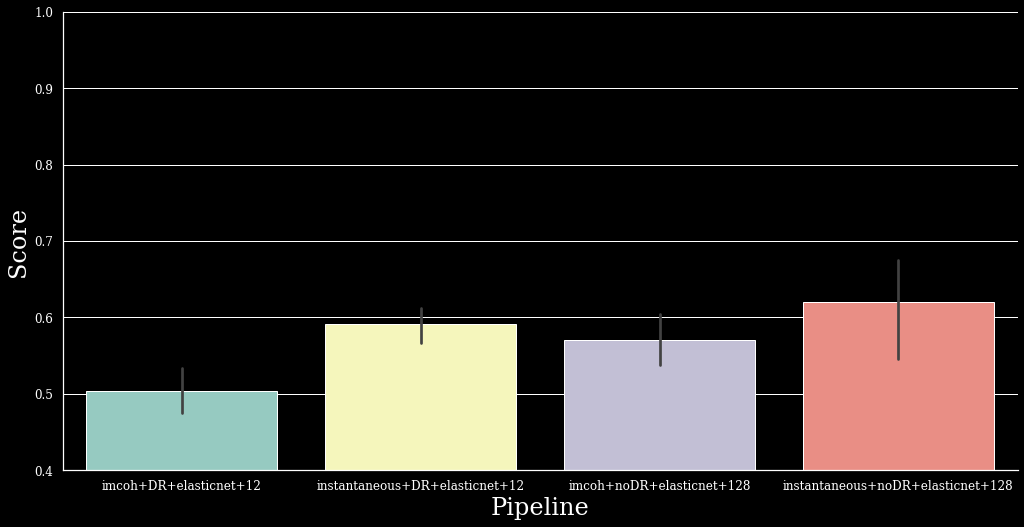

In [11]:
results_analysis = pd.read_csv(
    "results_DR_Schirrmeister.csv"
)

plt.close("all")
plt.style.use("dark_background")
g = sns.catplot(
    data=results_analysis,
    x="pipeline",
    y="score",
    kind="bar",
    #saturation=0.5,
    #order=list_fc_ens,
    height=7,
    aspect=2,
)
plt.ylim((0.4, 1))
plt.xticks(range(len(results_analysis["pipeline"].unique())),
           fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Pipeline", fontsize=24)
plt.ylabel("Score", fontsize=24)
plt.savefig(
    "DimRed_Schirrmeister_bar_Group_fc.pdf",
    dpi=300,
)

## Influence of the considered number of nodes

### Perform the classification

In [ ]:
threshold = [0.05]
percent_nodes = [10, 20, 30, 40, 50, 60, 70, 80, 90]
subj=[1]


results = list()
for f in freqbands:
    subjects = subj
    for subject in tqdm(subjects, desc="subject"):
        fmin = freqbands[f][0]
        fmax = freqbands[f][1]
        paradigm = LeftRightImagery(fmin=fmin, fmax=fmax)
        ep_, _, _ = paradigm.get_data(
                dataset=datasets, subjects=[subj[0]], return_epochs=True
            )
        nchan = ep_.info["nchan"]
        nb_nodes = [int(p / 100.0 * nchan) for p in percent_nodes]
        
        ppl_DR = {}
        gd = GetData(paradigm, datasets, subject)
        for sm in spectral_met:
            ft = FunctionalTransformer(
                        delta=1, ratio=0.5, method=sm, fmin=fmin, fmax=fmax
                 )

            for nb in nb_nodes:
                ft_DR = FC_DimRed(
                            threshold=threshold,
                            nb_nodes=[nb], 
                            chan_names=ep_.info["ch_names"],
                            method=sm,
                            classifier=FgMDM(metric="riemann", tsupdate=False)
                        )
                pname_postDR = sm + "+DR+elasticnet+" + str(nb) 
                ppl_DR[pname_postDR] = Pipeline(
                            steps=[
                                ("gd", gd),
                                ("sm", ft),
                                ("spd", EnsureSPD()),
                                ("DR", ft_DR),
                            ]
                            + step_fc
                        )


                
        all_ppl = {**ppl_DR}
        
         ###########################################################################
        # Train and evaluate
        ep_, y, metadata = paradigm.get_data(datasets, [subject], return_epochs=True)
        X = np.arange(len(y))
        for session in np.unique(metadata.session):
            ix = metadata.session == session
            cv = StratifiedKFold(5, shuffle=True, random_state=42)
            le = LabelEncoder()
            y_cv = le.fit_transform(y[ix])
            X_ = X[ix]
            y_ = y_cv
            for idx, (train, test) in enumerate(cv.split(X_, y_)):
                for ppn, ppl in tqdm(
                    all_ppl.items(), total=len(all_ppl), desc="pipelines"
                    ):
                    cvclf = clone(ppl)
                    cvclf.fit(X_[train], y_[train])
                    yp = cvclf.predict(X_[test])
                    acc = balanced_accuracy_score(y_[test], yp)
                    auc = roc_auc_score(y_[test], yp)
                    res_info = {
                            "subject": subject,
                            "session": "session_0",
                            "channels": nchan,
                            "n_sessions": 1,
                            "FreqBand": "defaultBand",
                            "dataset": datasets.code.replace(" ", "-"),
                            "fmin": fmin,
                            "fmax": fmax,
                            "samples": len(y_),
                            "time": 0.0,
                            "split": idx,
                        }
                    res = {
                            "score": auc,
                            "accuracy": acc,
                            "pipeline": ppn,
                            "n_dr": int(ppn.split('+')[3]), # to retrieve nb of nodes from the pipeline name
                            "thres": 0,
                            **res_info,
                        }
                    results.append(res)

# save results
results_analysis = pd.DataFrame(results)
results_analysis.to_csv("./results_DR_Schirrmeister_nb_nodes.csv")

### Plot the results

In [ ]:
# todo : retrieve the acc when no DR to use it as a baseline - horizontal line in the plot
results_analysis = pd.read_csv(
    "results_DR_Schirrmeister_nb_nodes.csv"
)

plt.close("all")
plt.style.use("dark_background")

results_analysis["score"] = results_analysis.score.astype(float)
g = sns.relplot(
        data=results_analysis,
        x="n_dr",
        y="score",
        hue="pipeline",
        kind="line",
        height=3,
        aspect=2,
    )
leg = g._legend
leg.set_bbox_to_anchor([1, 0.7])
plt.ylim(0.4, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Number of nodes", fontsize=24)
plt.ylabel("Score", fontsize=24)
plt.savefig(
        "DimRed_Schirrmeister_line_nb_nodes.pdf",
        dpi=300,
    )

## References:
- papers connectivity?
- Paper ICASSP
- Paper TBME + link to the associated repo?